# Oracle SAT solver with 1 solution


#### Satisfy to following 3-SAT
(1)\
(x ∨ y) ∧ ¬y

### In QC, we know how to implement the AND operator -> (Multi-Controlled X gate)
### What about the OR?

##### De Morgan
¬(a ∧ b) = ¬a ∨ ¬b \
¬(a ∨ b) = ¬a ∧ ¬b

#### Let us rewrite (1)
$(x ∨ y) ∧ ¬y = $

$¬(¬x ∧ ¬y) ∧ ¬y$



$w_0 = ¬x ∧ ¬y$ 

$w_1 = ¬y$ 


$¬w_0 ∧ w_1$

Now the SAT instance is expressed in terms of only AND -> happy :)

Spoiler: the solution is 01 (order: yx)

Since we already know that exists a single solution, then the number of repetitions of (oracle-diffuser) is given by the formula: 

$\frac{\pi}{4} \sqrt{2^n}$, where $n$ is the number of variables, respectively $x, y$

In [130]:
import qiskit
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, Aer
from qiskit.extensions import Initialize, UnitaryGate
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city

from qiskit.circuit.library import CPhaseGate,CU1Gate, CRXGate, MCXGate

from numpy import pi

## Diffuser

In [147]:
def get_diffuser(n_var):
    qvar = QuantumRegister(n_var)
    qtarget = QuantumRegister(1)
    diffuser = QuantumCircuit(qvar, qtarget, name='diffuser')
    diffuser.h(qvar)
    diffuser.x(qvar)
    diffuser.append(MCXGate(len(qvar)), qvar[0:]+qtarget[0:])
    diffuser.x(qvar)
    diffuser.h(qvar)
    return diffuser

## Oracle

In [148]:
def get_oracle(n_var):
    oq_n = QuantumRegister(n, 'x')
    oq_w = QuantumRegister(m, 'w')
    oq_checker = QuantumRegister(1, 'checker')
    oracle = QuantumCircuit(oq_n, oq_w, oq_checker, name='oracle')
    
    #clause: (¬x ∧ ¬y)
    n_variables_clause_1 = 2
    oracle.x(oq_n[0])
    oracle.x(oq_n[1])
    oracle.append(MCXGate(n_variables_clause_1), [oq_n[0], oq_n[1], oq_w[0]])
    oracle.x(oq_n[0])
    oracle.x(oq_n[1])
    
    #clause: ¬y
    n_variables_clause_2 = 1
    oracle.x(oq_n[1])
    oracle.append(MCXGate(n_variables_clause_2), [oq_n[1], oq_w[1]])
    oracle.x(oq_n[1])

    #clause: ¬(¬x ∧ ¬y) ∧ ¬y
    oracle.barrier()
    oracle.x(oq_w[0])
    oracle.append(MCXGate(len(oq_w)), oq_w[0:]+oq_checker[0:])
    oracle.x(oq_w[0])
    
    
    #uncomputation
    oracle.barrier()
    n_variables_clause_2 = 1
    oracle.x(oq_n[1])
    oracle.append(MCXGate(n_variables_clause_2), [oq_n[1], oq_w[1]])
    oracle.x(oq_n[1])


    oracle.barrier()
    oracle.x(oq_n[0])
    oracle.x(oq_n[1])
    oracle.append(MCXGate(n_variables_clause_1), [oq_n[0], oq_n[1], oq_w[0]])
    oracle.x(oq_n[0])
    oracle.x(oq_n[1])

    return oracle

# Quantum Circuit for the SAT instance

In [149]:
n = 2 #number of variables
m = 2 #number of clauses

q_x = QuantumRegister(1, 'x')
q_y = QuantumRegister(1, 'y')

q_w = QuantumRegister(m, 'w') #working qubits: for each clauses, 1 working qubit storing the result
q_checker = QuantumRegister(1, 'checker')

c_n = ClassicalRegister(n, 'res')

sat_solver = QuantumCircuit(q_x, q_y, q_w, q_checker, c_n)

## Step 1: Generate all the possible assignments for the boolean formula 

In [150]:
sat_solver.h(q_x) 
sat_solver.h(q_y) 

## Step 2 - 3: Apply Oracle and Diffuser

In [151]:
repetitions = math.floor(math.pi/4 * math.sqrt(2**n))

for i in range(repetitions):
    sat_solver.append(get_oracle(n), q_x[0:]+q_y[0:]+q_w[0:]+[q_checker])
    sat_solver.append(get_diffuser(n), q_x[0:]+q_y[0:]+[q_checker])

### Oracle Circuit

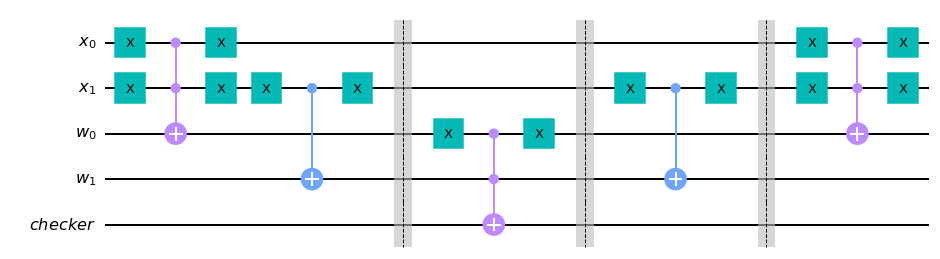

In [152]:
get_oracle(n).draw(output='mpl')

### Diffuser Circuit

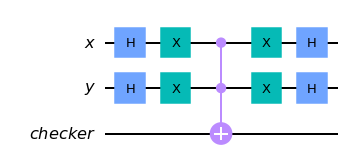

In [153]:
get_diffuser(n).draw(output='mpl')

## Step 4: Measurements

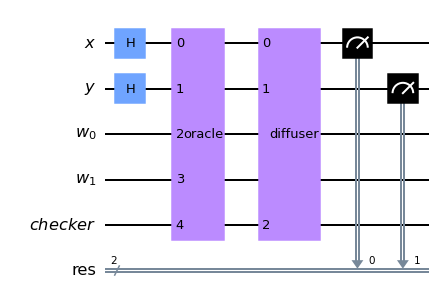

In [120]:
sat_solver.measure(q_x[0],c_n[0])
sat_solver.measure(q_y[0],c_n[1])


sat_solver.draw('mpl')

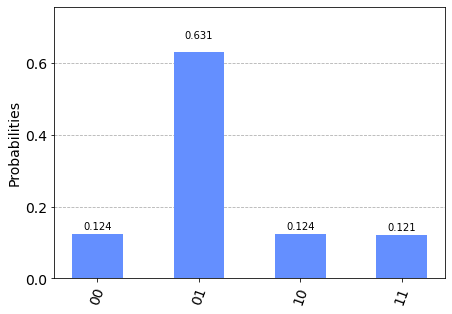

In [121]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(sat_solver, simulator, shots=4096).result()
counts = result.get_counts(sat_solver)
plot_histogram(counts)

## The solution is:
- 01 \
(order: $yx$)